<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>


In [20]:
mystock = 'icui'
minmax_period = 28

In [21]:
# Load Data and set options
import stockdatalib as sd
import pandas as pd
from collections import defaultdict 
from datetime import datetime

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
# files: screener_results.csv, constituents_csv.csv
stock_count, stock_fields, sp_df = sd.init_stocks_data('./data/','custom_stocklist.csv')
#sp_df

In [22]:
# Print Basic Info
sd.set_stock(mystock)
stock_info = sd.get_stock_info(mystock)
# Get stock company information
company_name = stock_info['name'][0]
company_sector = stock_info['sector'][0]
print('Symbol:'+mystock.upper(), ',Company:'+company_name,',Sector:'+company_sector)
squote = sd.quote(mystock)
if not squote.empty:
    print('Closed $'+str(squote.close[0]),'on',squote.date[0])
    print('https://snapshot.fidelity.com/fidresearch/snapshot/landing.jhtml#/research?symbol='+mystock.upper()+'&appCode=')

Symbol:ICUI ,Company:ICU Medical Inc ,Sector:Health Care
Closed $187.36 on 2020-05-12 20:00:02
https://snapshot.fidelity.com/fidresearch/snapshot/landing.jhtml#/research?symbol=ICUI&appCode=


In [23]:
# Stats
sd.key_stat(mystock)

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,icui,2020-03-31,20780000.0,328607000.0,20381000.0,270.717702,0.81,16834000.0,0.042774,121415000.0,0.582194


In [24]:
# Get stock data and Set range
price_df = sd.GetStockDataFrame(mystock)
price_df = sd.DatesRange(price_df, '2017-08-01') # limit the data since a specific past date or a range

In [25]:
# Print range table
rc = ''
rec_columns=['Symbol','Name','Sector','Recommendation','Close','BuyAt','SellAt']
record = defaultdict(list) 
recomm_list = []
if not squote.empty:
    print('Closed $'+str(squote.close[0]),'on',squote.date[0])

if not price_df.empty:
    rc, price_df2, low_df, hi_df, action_df = sd.GetBuySellEnvelope(mystock,price_df, minmax_period)
    if not rc:
        print("Function Failed")
    else:
        s = mystock
        if(action_df['Recommendation'][0] == 'buy'):
            record = {'Symbol':s.upper(),'Name': stock_info['name'][0], 'Sector':stock_info['sector'][0],
                'Recommendation':'BUY','Close':sd.quote(s).close[0],'BuyAt':action_df['BuyAt'][0],
                'SellAt':action_df['SellAt'][0],'Upside $': round( action_df['SellAt'][0] - sd.quote(s).close[0],2),
                'Upside %': str( round( 100 * ((action_df['SellAt'][0] - sd.quote(s).close[0] )/sd.quote(s).close[0] )  ,2) )+'%',
                'Ave. Hold (days)': 0}

            recomm_list.append(record)
            recomm_df = pd.DataFrame(recomm_list)

recomm_df

Closed $187.36 on 2020-05-12 20:00:02


,Symbol,Name,Sector,Recommendation,Close,BuyAt,SellAt,Upside $,Upside %,Ave. Hold (days)
0,ICUI,ICU Medical Inc,Health Care,BUY,187.36,187.36,225.6,38.24,20.41%,0


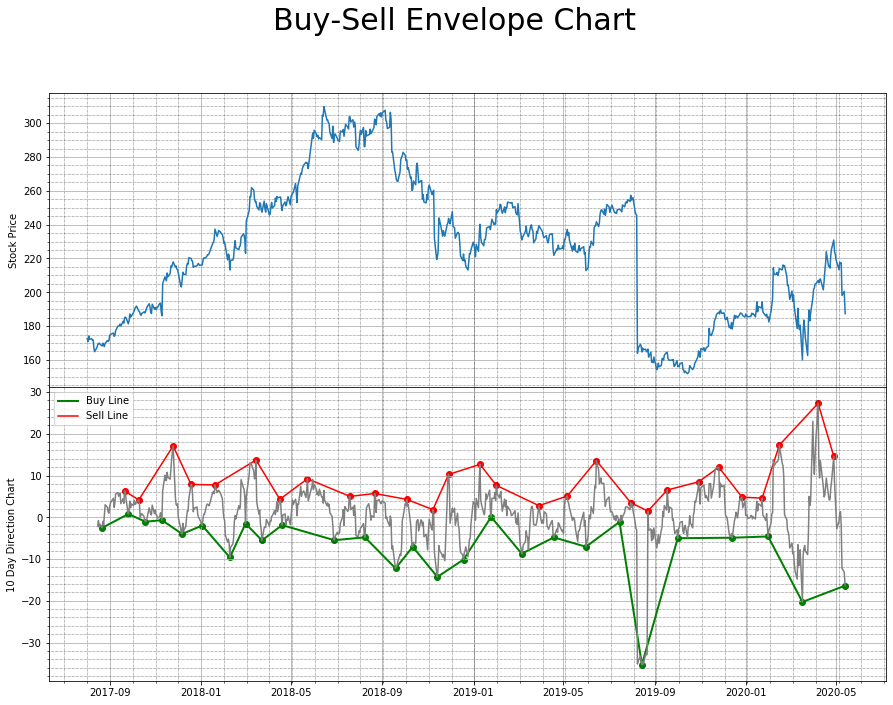

Closed $187.36 on 2020-05-12 20:00:02
Price change range is from  -7.04% to 8.57%
Buy range from  187.36 to 203.41
Last Buy signal on  2020-05-12 20:00:02 Close price was $ 187.36
Last Sell signal on  2020-04-27 13:30:00 Close price was $ 230.89


In [26]:
# Sell-Buy Range
if(not price_df.empty):
    price_df3, low_df, hi_df = sd.PlotBuySellEnvelope(price_df, 10)

    print('Closed $'+str(squote.close[0]),'on',squote.date[0])
    low_df.dropna(inplace=True)
    hi_df.dropna(inplace=True)

    date_last_buy = low_df.index[-1]
    date_last_sell = hi_df.index[-1]

    price_last_buy = price_df3[price_df3.index == low_df.index[-1]][0]
    price_last_sell = price_df3[price_df3.index == hi_df.index[-1]][0]
 
    ave_min_delta = low_df.mean()
    ave_max_delta = hi_df.mean()
    print("Price change range is from ",str(round(ave_min_delta,2))+"% to", str(round(ave_max_delta,2))+"%")

    if date_last_buy > date_last_sell:
        print("Buy range from ",round( price_last_buy,2), "to", 
              round( price_last_buy + (price_last_buy * ave_max_delta / 100), 2))
    else:
        print("Sell range from ",round( price_last_sell,2), "to", 
              round(price_last_sell + (price_last_sell * ave_min_delta / 100) ,2))

    print("Last Buy signal on ",date_last_buy,"Close price was $",round(price_last_buy,2))
    print("Last Sell signal on ",date_last_sell,"Close price was $",round(price_last_sell,2))

<Figure size 1080x432 with 0 Axes>

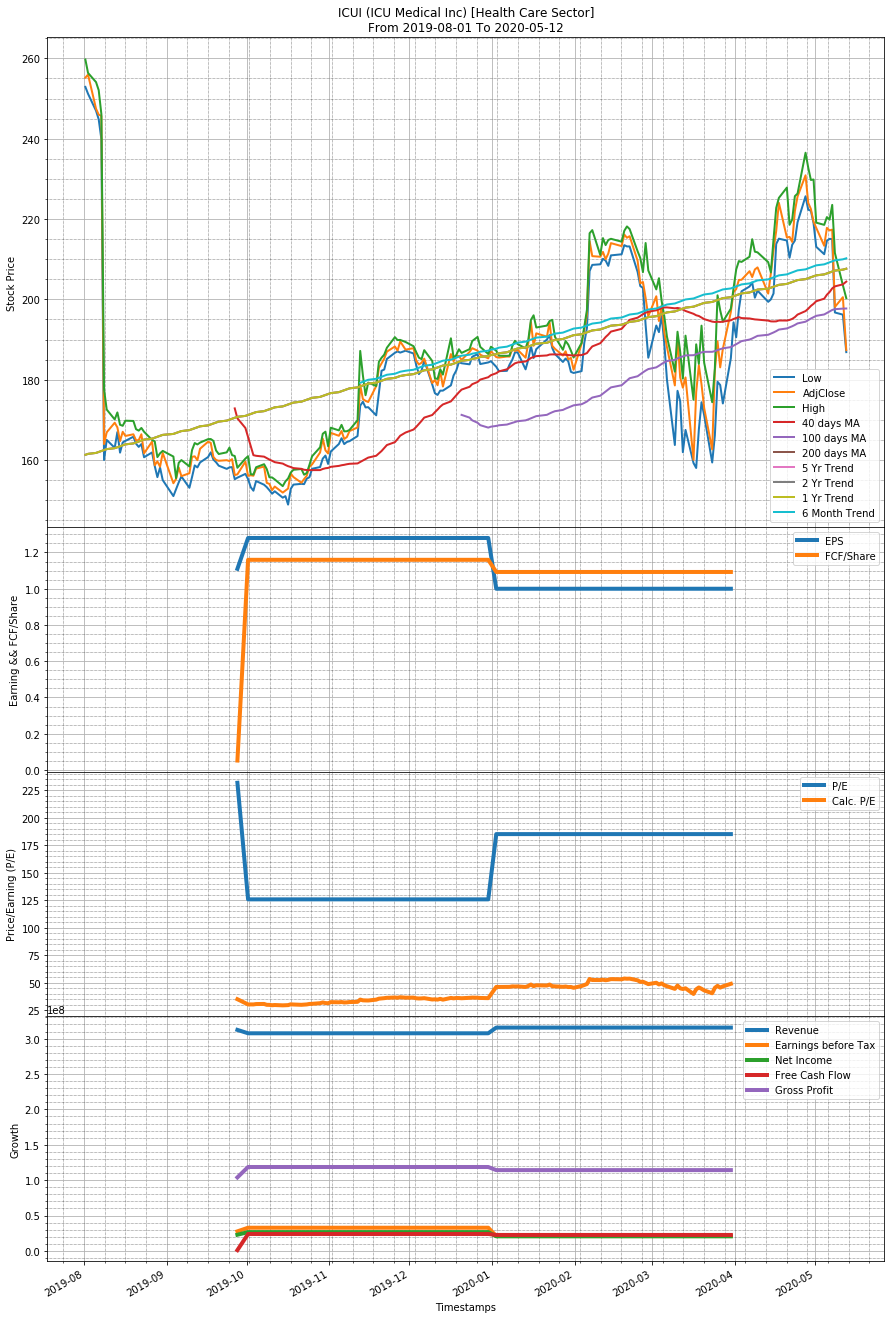

In [27]:
# Plot stock basic charts
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_df = sd.DatesRange(price_df, '2019-08-01') # limit the data since a specific past date or a range

    linear_trends = sd.PlotBasicCharts(mystock,price_df)

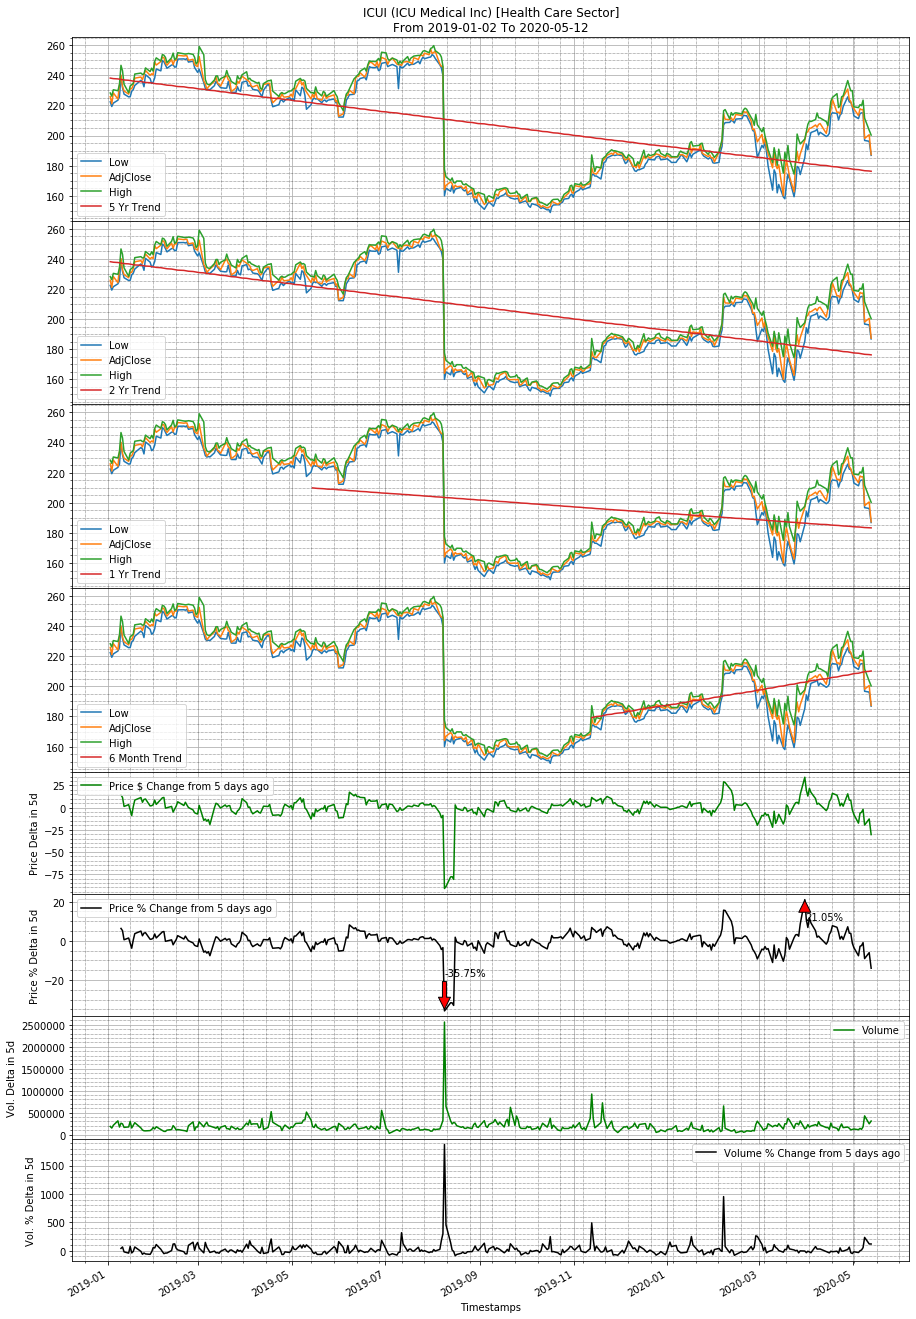

In [28]:
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_df = sd.DatesRange(price_df, '2019-01-01')
    price_data_df, maximums_table_df, trends = sd.PlotTrends(mystock,price_df)

In [29]:
if(not price_df.empty):
    for k,v in trends.items():
        print(k,round(v[1],4))

5y Trend -0.1809
2y Trend -0.1809
1y Trend -0.1057
6m Trend 0.25


In [30]:
if(not price_df.empty):
    maximums_table_df

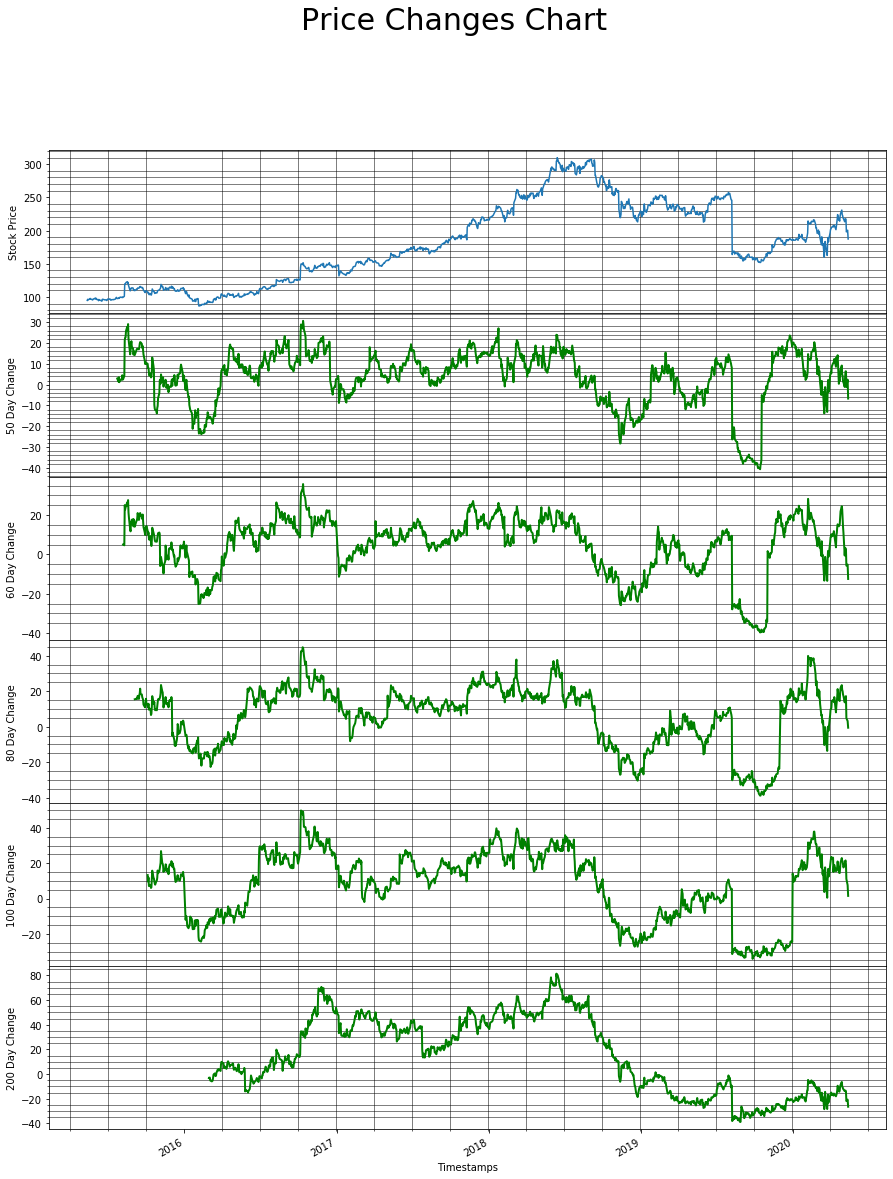

In [31]:
# Set the stock and get the prices dataframe
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    # You can limit the range if needed
    #price_df = sd.DatesRange(price_df, '2016-02-01')
   
    sd.PlotPriceChangesPercent(price_df,[50,60,80,100,200])

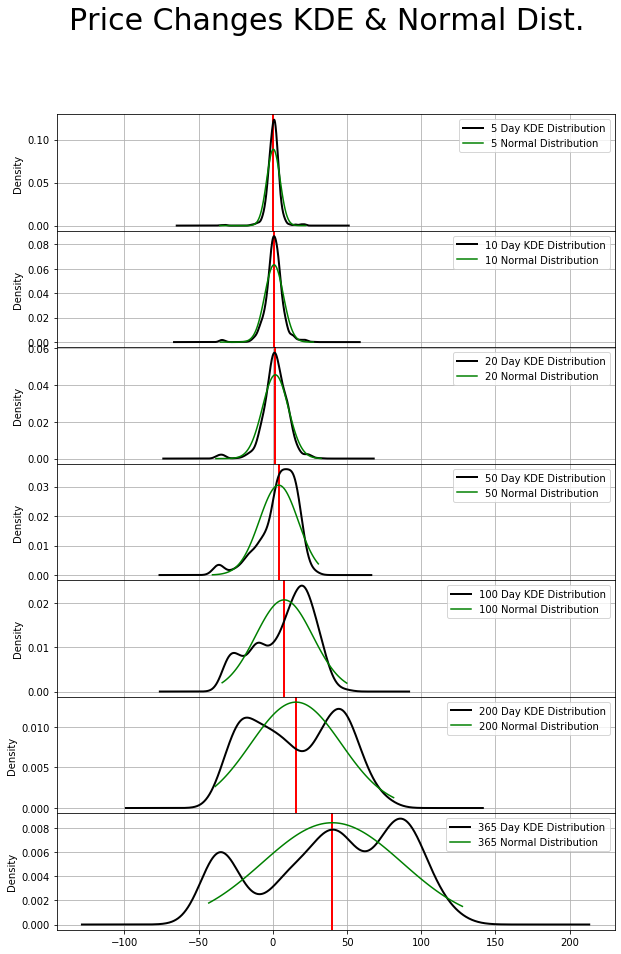

In [32]:
# Set the stock and get the prices dataframe
price_df = sd.GetStockDataFrame(mystock)
if(not price_df.empty):
    price_changes, stats = sd.PlotPriceChangesKDE(price_df,[5,10,20,50,100,200,365])
    stats